# Logistic Regression - From Scratch Implementation

This notebook implements Logistic Regression classifier from scratch using gradient descent and evaluates it on the credit risk dataset.

## Contents:
1. Import Libraries
2. Logistic Regression Implementation
3. Data Loading and Preprocessing
4. Model Training
5. Model Evaluation
6. Visualizations

## 1. Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    classification_report,
    roc_curve
)
from sklearn.utils.class_weight import compute_class_weight
import os
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Logistic Regression Implementation

Implementing Logistic Regression from scratch with:
- Sigmoid activation function
- Gradient descent optimization
- Binary cross-entropy loss
- Class weight support for imbalanced datasets

In [ ]:
class LogisticRegression:
    """
    Logistic Regression classifier implemented from scratch using gradient descent.
    
    Parameters:
    -----------
    learning_rate : float, default=0.01
        Learning rate for gradient descent
    n_iterations : int, default=1000
        Number of iterations for gradient descent
    fit_intercept : bool, default=True
        Whether to add intercept term
    verbose : bool, default=False
        Whether to print loss during training
    class_weight : str, default=None
        'balanced' to use balanced class weights
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, fit_intercept=True, verbose=False, class_weight=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.class_weight = class_weight
        self.weights = None
        self.bias = None
        self.losses = []
    
    def _sigmoid(self, z):
        """Sigmoid activation function"""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _compute_loss(self, y_true, y_pred):
        """Compute binary cross-entropy loss"""
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        n_samples = len(y_true)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def fit(self, X, y):
        """Fit the logistic regression model using gradient descent"""
        X = np.array(X)
        y = np.array(y)
        
        n_samples, n_features = X.shape
        
        # Calculate sample weights based on class weights
        sample_weights = np.ones(n_samples)
        if self.class_weight == 'balanced':
            classes = np.unique(y)
            n_samples_per_class = np.bincount(y.astype(int))
            weights_per_class = n_samples / (len(classes) * n_samples_per_class)
            
            for i, cls in enumerate(classes):
                sample_weights[y == cls] = weights_per_class[i]
        
        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient descent
        for i in range(self.n_iterations):
            # Linear model
            linear_model = np.dot(X, self.weights) + self.bias
            
            # Apply sigmoid function
            y_predicted = self._sigmoid(linear_model)
            
            # Compute weighted gradients
            errors = (y_predicted - y) * sample_weights
            dw = (1 / n_samples) * np.dot(X.T, errors)
            db = (1 / n_samples) * np.sum(errors)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Compute and store loss
            if self.verbose and i % 100 == 0:
                loss = self._compute_loss(y, y_predicted)
                self.losses.append(loss)
                print(f"Iteration {i}: Loss = {loss:.4f}")
        
        return self
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        X = np.array(X)
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        """Predict class labels"""
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)
    
    def score(self, X, y):
        """Calculate accuracy score"""
        predictions = self.predict(X)
        return np.mean(predictions == y)

print("✓ LogisticRegression class defined!")

✓ LogisticRegression class defined!


## 3. Load and Preprocess Data

In [ ]:
# Load the dataset
data_path = '../clean_data.csv' if os.path.exists('../clean_data.csv') else 'clean_data.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())
print(f"\nTarget distribution:")
print(df['Target'].value_counts())

Dataset shape: (9709, 20)

First few rows:
        ID  Gender  Own_car  Own_property  Work_phone  Phone  Email  \
0  5008804       1        1             1           1      0      0   
1  5008806       1        1             1           0      0      0   
2  5008808       0        0             1           0      1      1   
3  5008812       0        0             1           0      0      0   
4  5008815       1        1             1           1      1      1   

   Unemployed  Num_children  Num_family  Account_length  Total_income  \
0           0             0           2              15      427500.0   
1           0             0           2              29      112500.0   
2           0             0           1               4      270000.0   
3           1             0           1              20      283500.0   
4           0             0           2               5      270000.0   

         Age  Years_employed           Income_type  \
0  32.868574       12.435574         

In [ ]:
# Separate features and target
X = df.drop(['ID', 'Target'], axis=1)
y = df['Target']

print(f"Feature columns: {X.columns.tolist()}")

# Encode categorical variables
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns: {categorical_columns}")

if categorical_columns:
    print("Encoding categorical variables...")
    le_dict = {}
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        le_dict[col] = le

print("✓ Data preprocessing complete!")

Feature columns: ['Gender', 'Own_car', 'Own_property', 'Work_phone', 'Phone', 'Email', 'Unemployed', 'Num_children', 'Num_family', 'Account_length', 'Total_income', 'Age', 'Years_employed', 'Income_type', 'Education_type', 'Family_status', 'Housing_type', 'Occupation_type']

Categorical columns: ['Income_type', 'Education_type', 'Family_status', 'Housing_type', 'Occupation_type']
Encoding categorical variables...
✓ Data preprocessing complete!


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Train-test split and scaling complete!")

Training set size: (7767, 18)
Testing set size: (1942, 18)
✓ Train-test split and scaling complete!


## 4. Train Logistic Regression Model

In [ ]:
# Train with balanced class weights
model = LogisticRegression(
    learning_rate=0.01,
    n_iterations=5000,
    class_weight='balanced',
    verbose=True
)

print("="*60)
print("Training Logistic Regression Model...")
print("="*60)
model.fit(X_train_scaled, y_train)
print("\n✓ Model training complete!")

Training Logistic Regression Model...
Iteration 0: Loss = 0.6931
Iteration 100: Loss = 0.6908
Iteration 200: Loss = 0.6893
Iteration 300: Loss = 0.6881
Iteration 400: Loss = 0.6871
Iteration 500: Loss = 0.6862
Iteration 600: Loss = 0.6854
Iteration 700: Loss = 0.6847
Iteration 800: Loss = 0.6841
Iteration 900: Loss = 0.6835
Iteration 1000: Loss = 0.6830
Iteration 1100: Loss = 0.6825
Iteration 1200: Loss = 0.6822
Iteration 1300: Loss = 0.6818
Iteration 1400: Loss = 0.6815
Iteration 1500: Loss = 0.6813
Iteration 1600: Loss = 0.6811
Iteration 1700: Loss = 0.6809
Iteration 1800: Loss = 0.6807
Iteration 1900: Loss = 0.6806
Iteration 2000: Loss = 0.6804
Iteration 2100: Loss = 0.6803
Iteration 2200: Loss = 0.6803
Iteration 2300: Loss = 0.6802
Iteration 2400: Loss = 0.6801
Iteration 2500: Loss = 0.6801
Iteration 2600: Loss = 0.6800
Iteration 2700: Loss = 0.6800
Iteration 2800: Loss = 0.6799
Iteration 2900: Loss = 0.6799
Iteration 3000: Loss = 0.6799
Iteration 3100: Loss = 0.6799
Iteration 3200

## 5. Model Evaluation

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train_scaled, threshold=0.5)
y_test_pred = model.predict(X_test_scaled, threshold=0.5)
y_test_proba = model.predict_proba(X_test_scaled)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_mcc = matthews_corrcoef(y_test, y_test_pred)

print("="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print("\n--- Test Set Performance ---")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"AUC Score: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1 Score:  {test_f1:.4f}")
print(f"MCC:       {test_mcc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\n--- Confusion Matrix ---")
print(cm)
print(f"\nTrue Negatives:  {cm[0][0]}")
print(f"False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]}")
print(f"True Positives:  {cm[1][1]}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_test_pred))

MODEL EVALUATION RESULTS

Training Accuracy: 0.5673

--- Test Set Performance ---
Accuracy:  0.5314
AUC Score: 0.5456
Precision: 0.1485
Recall:    0.5370
F1 Score:  0.2327
MCC:       0.0458

--- Confusion Matrix ---
[[894 791]
 [119 138]]

True Negatives:  894
False Positives: 791
False Negatives: 119
True Positives:  138

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.53      0.66      1685
           1       0.15      0.54      0.23       257

    accuracy                           0.53      1942
   macro avg       0.52      0.53      0.45      1942
weighted avg       0.79      0.53      0.61      1942



## 6. Visualizations

Create comprehensive visualizations including:
- Confusion Matrix Heatmap
- ROC Curve
- Training Loss Curve
- Feature Importance
- Metrics Summary

✓ Visualization saved to: visualizations/logistic_regression_analysis.png


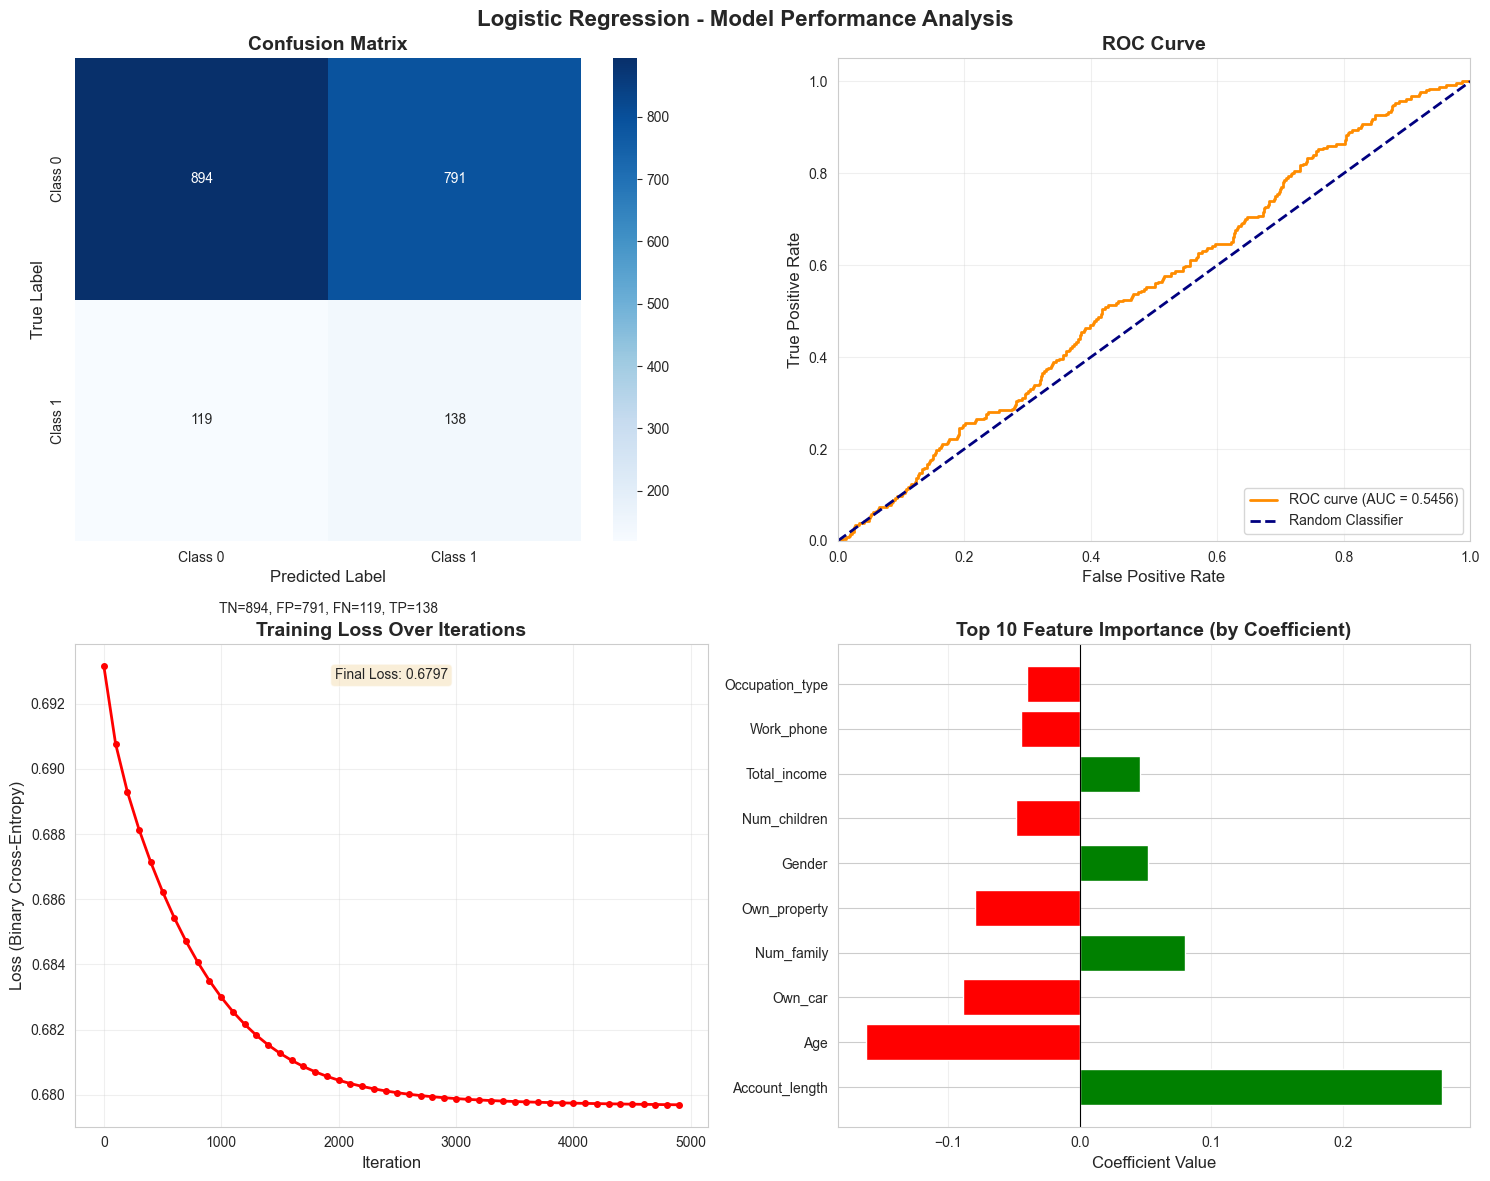

In [ ]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Logistic Regression - Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'],
            ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('True Label', fontsize=12)
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
axes[0, 0].text(0.5, -0.15, f'TN={cm[0][0]}, FP={cm[0][1]}, FN={cm[1][0]}, TP={cm[1][1]}', 
                ha='center', transform=axes[0, 0].transAxes, fontsize=10)

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(True, alpha=0.3)

# 3. Training Loss Curve
if model.losses:
    axes[1, 0].plot(range(0, model.n_iterations, 100), model.losses, 
                    color='red', linewidth=2, marker='o', markersize=4)
    axes[1, 0].set_xlabel('Iteration', fontsize=12)
    axes[1, 0].set_ylabel('Loss (Binary Cross-Entropy)', fontsize=12)
    axes[1, 0].set_title('Training Loss Over Iterations', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].text(0.5, 0.95, f'Final Loss: {model.losses[-1]:.4f}', 
                    ha='center', va='top', transform=axes[1, 0].transAxes, 
                    fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Feature Importance (Top 10 features by coefficient magnitude)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.weights
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False).head(10)

colors = ['green' if x > 0 else 'red' for x in feature_importance['Coefficient']]
axes[1, 1].barh(range(len(feature_importance)), feature_importance['Coefficient'], color=colors)
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['Feature'])
axes[1, 1].set_xlabel('Coefficient Value', fontsize=12)
axes[1, 1].set_title('Top 10 Feature Importance (by Coefficient)', fontsize=14, fontweight='bold')
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()

# Save the figure
os.makedirs('../visualizations', exist_ok=True)
plt.savefig('../visualizations/logistic_regression_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to: visualizations/logistic_regression_analysis.png")
plt.show()

✓ Metrics chart saved to: visualizations/logistic_regression_metrics.png


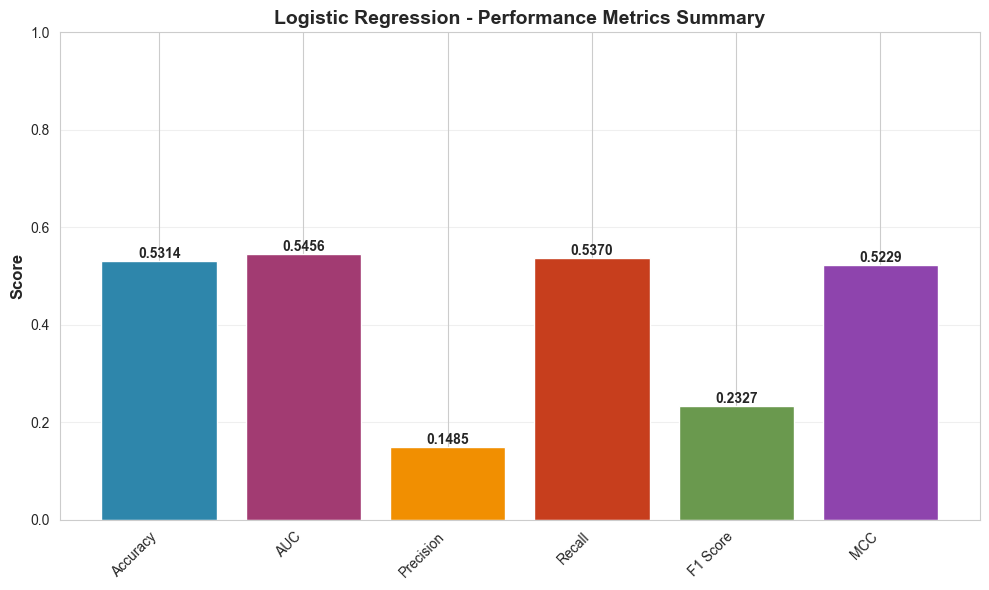

In [ ]:
# Metrics Comparison Bar Chart
fig2, ax = plt.subplots(figsize=(10, 6))
metrics_data = {
    'Accuracy': test_accuracy,
    'AUC': test_auc,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1 Score': test_f1,
    'MCC': (test_mcc + 1) / 2  # Normalize MCC from [-1,1] to [0,1] for visualization
}

bars = ax.bar(metrics_data.keys(), metrics_data.values(), 
              color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#8E44AD'])
ax.set_ylim([0, 1])
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Logistic Regression - Performance Metrics Summary', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../visualizations/logistic_regression_metrics.png', dpi=300, bbox_inches='tight')
print("✓ Metrics chart saved to: visualizations/logistic_regression_metrics.png")
plt.show()

## Summary for README

Copy the results below to update your README.md file:

In [ ]:
print("="*60)
print("SUMMARY FOR README")
print("="*60)
print("\nLogistic Regression Results:")
print(f"| Logistic Regression | {test_accuracy:.4f} | {test_auc:.4f} | {test_precision:.4f} | {test_recall:.4f} | {test_f1:.4f} | {test_mcc:.4f} |")
print("\n" + "="*60)
print("✓ Training and Evaluation Complete!")
print("="*60)

SUMMARY FOR README

Logistic Regression Results:
| Logistic Regression | 0.5314 | 0.5456 | 0.1485 | 0.5370 | 0.2327 | 0.0458 |

✓ Training and Evaluation Complete!
